In [1]:
from datasets import load_dataset
import os
import torch
import torch.optim as optim
from utils.lstm_gru_model import *
from utils.lstm_gru_utils import *
from utils.utils import *

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Data preparation

In [2]:
dataset = load_dataset("rotten_tomatoes")
trn_dataset = dataset["train"]
val_dataset = dataset["validation"]
tst_dataset = dataset["test"]

In [3]:
# Obtain a list of unique words from the train set
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

# Pass it in to the load_word2vec function along w the relative filepath of the embedding file
word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_oov.npy")

In [4]:
word_index = {
    word: i for i, word in enumerate(
        word2vec_model.index_to_key
    )
}

In [5]:
trn_sentences, trn_labels = prepare_data(
    trn_dataset["text"],
    trn_dataset["label"],
    word_index=word_index
)
val_sentences, val_labels = prepare_data(
    val_dataset["text"],
    val_dataset["label"],
    word_index=word_index
)
tst_sentences, tst_labels = prepare_data(
    tst_dataset["text"],
    tst_dataset["label"],
    word_index=word_index
)

In [6]:
BATCH_SIZE = 32

trn_dataloader = create_dataloader(
    trn_sentences,
    trn_labels,
    BATCH_SIZE,
    shuffle=True)
val_dataloader = create_dataloader(
    val_sentences,
    val_labels,
    BATCH_SIZE,
    shuffle=False)
tst_dataloader = create_dataloader(
    tst_sentences,
    tst_labels,
    BATCH_SIZE,
    shuffle=False)

# Model

### Using Last State

In [7]:
# Obtain a list of unique words from the train set
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

# Pass it in to the load_word2vec function along w the relative filepath of the embedding file
word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_oov.npy")

In [8]:
# Model instantiation
model = LSTMGRUHybridModel(
    embed_dim=350,
    lstm_hidden_dim=128,
    gru_hidden_dim=128,
    num_classes=1,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    embedding_matrix=word2vec_model.vectors,
    pooling_method="last_state"
)

In [9]:
# Training
train_losses, val_accuracies = train_lstm_gru_model(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optim.Adam(model.parameters(), lr=0.0001),
    criterion=torch.nn.BCELoss(),
    epochs=100,
    model_save_path="modelfiles/",
    early_stopping_patience=10,
    load_best_model_at_end=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    train_mode= "last_state"
)

Epoch 1/100, Training Loss: 0.6932
Accuracy: 0.4962
Model saved
Epoch 2/100, Training Loss: 0.6929
Accuracy: 0.5159
Model saved
Epoch 3/100, Training Loss: 0.6583
Accuracy: 0.6698
Model saved
Epoch 4/100, Training Loss: 0.4732
Accuracy: 0.6886
Model saved
Epoch 5/100, Training Loss: 0.3342
Accuracy: 0.7036
Model saved
Epoch 6/100, Training Loss: 0.2410
Accuracy: 0.6989
Epoch 7/100, Training Loss: 0.1655
Accuracy: 0.6914
Epoch 8/100, Training Loss: 0.1272
Accuracy: 0.6942
Epoch 9/100, Training Loss: 0.0844
Accuracy: 0.6886
Epoch 10/100, Training Loss: 0.0585
Accuracy: 0.7008
Epoch 11/100, Training Loss: 0.0376
Accuracy: 0.6970
Epoch 12/100, Training Loss: 0.0321
Accuracy: 0.6876
Epoch 13/100, Training Loss: 0.0208
Accuracy: 0.6829
Epoch 14/100, Training Loss: 0.0159
Accuracy: 0.6829
Epoch 15/100, Training Loss: 0.0104
Accuracy: 0.6801
Early stopping triggered


f:\OneDrive - Nanyang Technological University\Year 4 Sem 1\SC4002\sc4002\utils\lstm_gru_utils.py:177: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(to

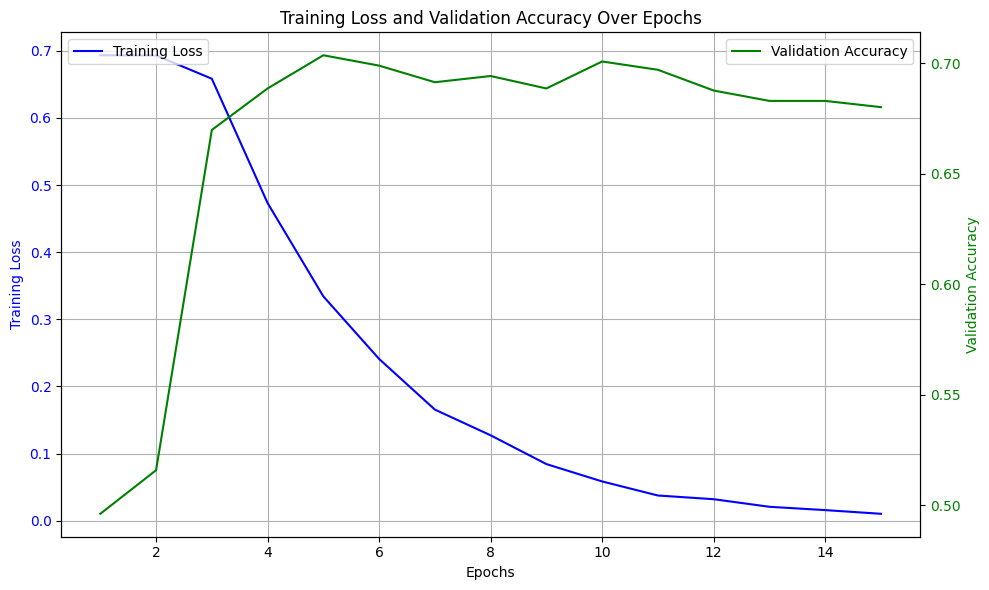

In [10]:
plot_training_progress(train_losses, val_accuracies)

In [11]:
last_state_test_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7439


### Using Attention

In [12]:
# Obtain a list of unique words from the train set
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

# Pass it in to the load_word2vec function along w the relative filepath of the embedding file
word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_oov.npy")

In [13]:
# Model instantiation
model = LSTMGRUHybridModel(
    embed_dim=350,
    lstm_hidden_dim=128,
    gru_hidden_dim=128,
    num_classes=1,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    embedding_matrix=word2vec_model.vectors,
    pooling_method="attention"
)

In [14]:
# Training
train_losses, val_accuracies = train_lstm_gru_model(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optim.Adam(model.parameters(), lr=0.0001),
    criterion=torch.nn.BCELoss(),
    epochs=100,
    model_save_path="modelfiles/",
    early_stopping_patience=10,
    load_best_model_at_end=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    train_mode="attention"
)

Epoch 1/100, Training Loss: 0.6929
Accuracy: 0.5497
Model saved
Epoch 2/100, Training Loss: 0.6448
Accuracy: 0.6745
Model saved
Epoch 3/100, Training Loss: 0.4827
Accuracy: 0.7101
Model saved
Epoch 4/100, Training Loss: 0.3493
Accuracy: 0.6989
Epoch 5/100, Training Loss: 0.2601
Accuracy: 0.7139
Model saved
Epoch 6/100, Training Loss: 0.1910
Accuracy: 0.7092
Epoch 7/100, Training Loss: 0.1388
Accuracy: 0.7026
Epoch 8/100, Training Loss: 0.0984
Accuracy: 0.7026
Epoch 9/100, Training Loss: 0.0694
Accuracy: 0.7054
Epoch 10/100, Training Loss: 0.0505
Accuracy: 0.6970
Epoch 11/100, Training Loss: 0.0357
Accuracy: 0.7092
Epoch 12/100, Training Loss: 0.0258
Accuracy: 0.7036
Epoch 13/100, Training Loss: 0.0192
Accuracy: 0.6989
Epoch 14/100, Training Loss: 0.0187
Accuracy: 0.7008
Epoch 15/100, Training Loss: 0.0127
Accuracy: 0.6961
Early stopping triggered


f:\OneDrive - Nanyang Technological University\Year 4 Sem 1\SC4002\sc4002\utils\lstm_gru_utils.py:177: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(to

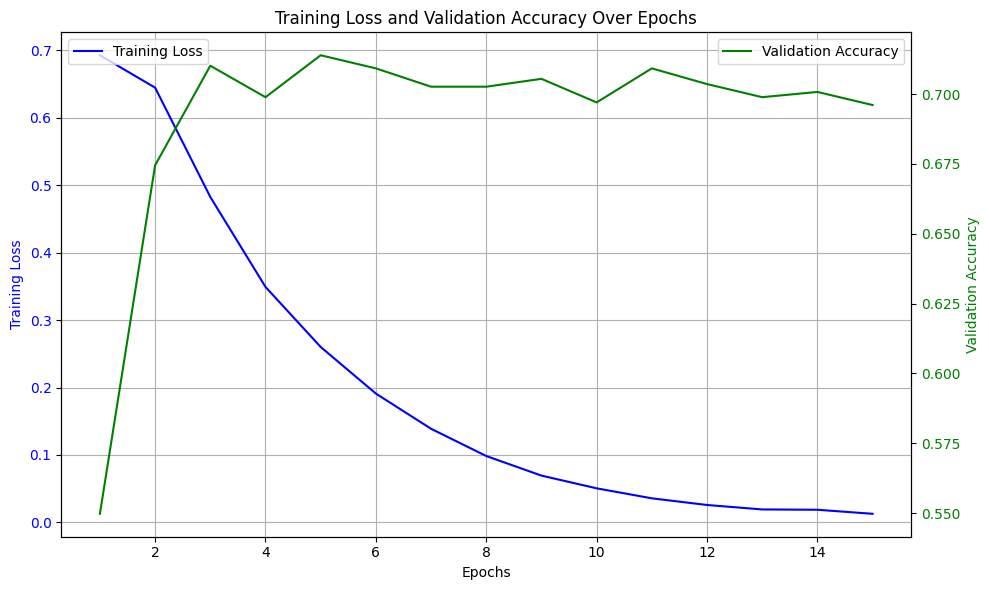

In [15]:
plot_training_progress(train_losses, val_accuracies)

In [16]:
attn_test_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7495


# Results

In [17]:
print(f"LSTM-GRU Hybrid model with Last State Test Accuracy: {last_state_test_accuracy:.4f}")
print(f"LSTM-GRU Hybrid model with Attention Test Accuracy:  {attn_test_accuracy:.4f}")

LSTM-GRU Hybrid model with Last State Test Accuracy: 0.7439
LSTM-GRU Hybrid model with Attention Test Accuracy:  0.7495
